In [1]:
import json
import pickle
import sys

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

sys.path.append('..')
from utils.amt_inout import bounded_curve, bounded_sigmoid
from utils.stock_loader import Loader

In [2]:
SYM = 'GDX'  # gold
START = '1965-01-01'
PARAM_PATH = '../data/inout_params_gdx.pkl'
loader = Loader([SYM], START)
df = loader.download()
df.set_index('Date', drop=True, inplace=True)
df.columns = [
    'open', 'high', 'low', 'close', 'value', 'logval',
    'intraday_change', 'day_to_day_change', 'overnight_change']
df.logval.fillna(method='ffill')
for adj in ['overnight_change', 'day_to_day_change']:
    df[adj] = pd.Series(
        np.concatenate([df[adj].values[1:], [np.nan]]), index=df.index)
print(df.shape)
df.head(10)

[*********************100%%**********************]  1 of 1 completed


Generating derived columns...
(4566, 9)


,open,high,low,close,value,logval,intraday_change,day_to_day_change,overnight_change
Date,,,,,,,,,
2006-05-22,36.520000,37.290001,35.869999,37.230000,32.197548,3.471890,1.019441,1.019608,1.013967
2006-05-23,37.750000,39.220001,37.750000,37.959999,32.828876,3.491309,1.005563,0.962065,0.978135
2006-05-24,37.130001,37.570000,35.869999,36.520000,31.583519,3.452635,0.983571,1.049288,1.018072
2006-05-25,37.180000,38.320000,36.980000,38.320000,33.140209,3.500747,1.030662,1.006002,1.010960
2006-05-26,38.740002,38.740002,37.770000,38.549999,33.339123,3.506732,0.995095,0.990143,1.024643
2006-05-30,39.500000,39.720001,38.110001,38.169998,33.010483,3.496825,0.966329,1.017815,1.019125
2006-05-31,38.900002,39.130001,38.119999,38.849998,33.598572,3.514484,0.998715,0.991763,0.957529
2006-06-01,37.200001,38.580002,37.169998,38.529999,33.321827,3.506213,1.035753,1.015572,1.020244
2006-06-02,39.310001,39.389999,38.799999,39.130001,33.840717,3.521665,0.995421,0.974444,1.029134


In [3]:
df.isnull().sum()

open                 0
high                 0
low                  0
close                0
value                0
logval               0
intraday_change      0
day_to_day_change    1
overnight_change     1
dtype: int64

In [4]:
df.fillna(method='ffill', inplace=True)
df.isnull().sum()

open                 0
high                 0
low                  0
close                0
value                0
logval               0
intraday_change      0
day_to_day_change    0
overnight_change     0
dtype: int64

In [5]:
df.high[(df.high != df.low)]

Date
2006-05-22    37.290001
2006-05-23    39.220001
2006-05-24    37.570000
2006-05-25    38.320000
2006-05-26    38.740002
                ...    
2024-07-08    36.160000
2024-07-09    36.369999
2024-07-10    37.169998
2024-07-11    38.150002
2024-07-12    38.310001
Name: high, Length: 4566, dtype: float64

In [6]:
SIM_START = pd.to_datetime('2006-05-22')  # first day of legit open/close values
SIM_START

Timestamp('2006-05-22 00:00:00')

In [7]:
len(df.index >= SIM_START)

4566

In [8]:
def get_random_params():
    k = np.random.uniform(1, 10)
    if np.random.choice([True, False]):
        k = 1/k
    return {
        'time_param': np.random.randint(5, 250),
        'method':     np.random.choice(['ew', 'ma', 'linear_ma', 'linear']),
        't':          np.random.uniform(0, 1),
        'k':          k,
        'as_q':       np.random.choice([True, False]),
        'transform_f': np.random.choice(['bounded_curve', 'bounded_sigmoid'])}

In [9]:
def tweak_best_params(params, factor=2, numeric_only=False):
    '''A small factor should have values very close to current, larger
    values allow wilder fluctuations'''
    time = params['time_param']
    upper = time * factor
    diff = upper - time
    time = np.random.randint(time - diff, upper)
    time = min(max(5, time), 1000)
    
    method = params['method']
    if not numeric_only:
        meths = ['ew', 'ma', 'linear_ma', 'linear']
        idx = meths.index(method)
        ps = np.array([1, 1, 1, 1])
        ps[idx] = factor
        ps = ps / ps.sum()
        method = np.random.choice(meths, p=ps)
    
    t = params['t']
    sd = 1 - 1 / (factor/2 + 1)
    t = min(max(np.random.normal(t, scale=sd), 0.001), 0.999)
    
    k = params['k']
    upper = k * factor
    diff = upper - k
    k = np.random.uniform(k - diff, upper)
    k = min(max(1/10, k), 10)
    
    as_q = params['as_q'] if numeric_only else np.random.choice([True, False]) 
    
    current_transform = params['transform_f']
    other_transform = 'bounded_curve' if current_transform == 'bounded_sigmoid' else 'bounded_sigmoid'
    p_current = 1 / factor
    transform_f = np.random.choice([current_transform, other_transform], p=[p_current, 1 - p_current])
    return {
        'time_param': time,
        'method': method,
        't': t,
        'k': k,
        'as_q': as_q,
        'transform_f': transform_f}

In [10]:
def get_ma(series: pd.Series, time_param: float | int, method: str):
    '''Calculate the moving average
    Args:
    - method: 'ew' | 'ma' | 'linear' | 'linear_ma'
    - time_param:
      - ew=True: (real) the halflife of the exponential weights (no. 
          of  time periods it takes for weight to drop from 1 to 0.5)
      - ew=False: (int) the ma window, or number of days to average 
   over
    '''
    if method == 'ew':
        trend = series.ewm(halflife=time_param, ignore_na=True).mean()
    elif method == 'ma':
        trend = series.rolling(window=int(time_param)).mean()
    elif method.startswith('linear'):
        trend = (series).rolling(window=int(time_param)).apply(lambda x: (x[-1] + x[0]) / 2)
        if method == 'linear_ma':
            trend = trend.rolling(window=int(time_param)).mean()
        trend.fillna(method='bfill', inplace=True)
    return trend

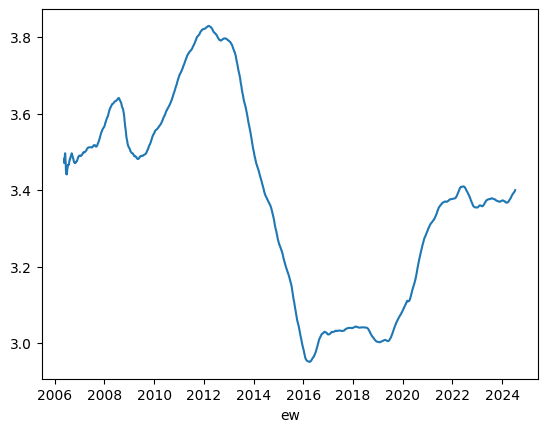

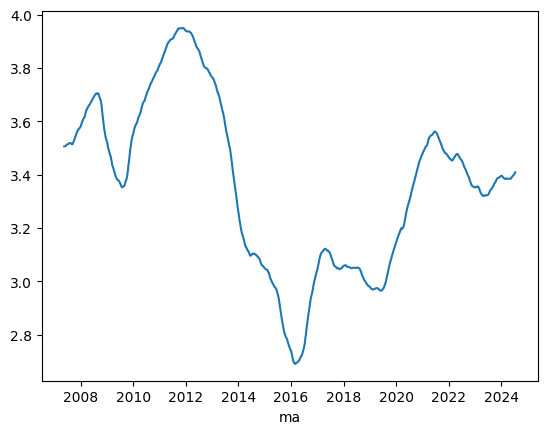

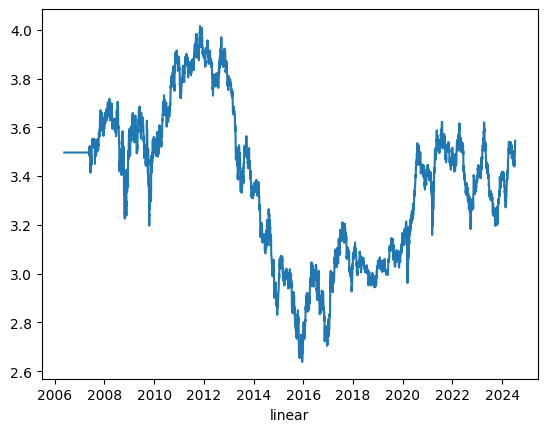

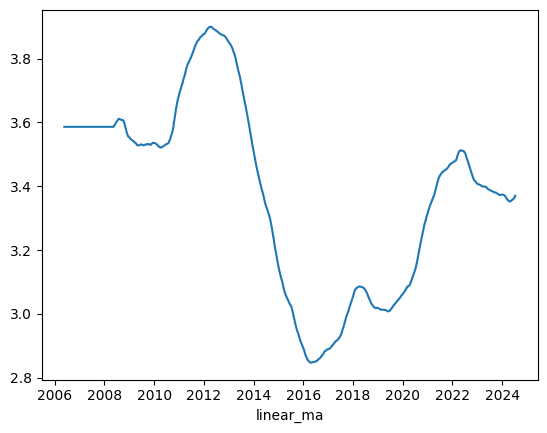

In [11]:
for method in ['ew', 'ma', 'linear', 'linear_ma']:
    plt.plot(get_ma(df.logval, 250, method))
    plt.xlabel(method)
    plt.show()

In [12]:
def get_trend_multiple(series, time_param, method, as_q):
    'Get deviates (as quantiles) relative to trend'
    trend = get_ma(series, time_param, method)
    factor = series / trend
    if as_q:
        factor = factor.rank() / len(factor)
    return factor

In [13]:
def rescale_minmax(series, mn=0, mx=1):
    s = series.copy()
    out_rng = mx - mn
    obs_min = s.min()
    s -= obs_min
    obs_max = s.max()
    s /= obs_max
    s *= out_rng
    s += mn
    return s

In [14]:
def calculate_next_row(row):
    invested = row.invested * row.overnight_change
    total = invested + row.reserve
    target_in = total * row.amt_in
    diff = target_in - invested  # if diff+ buy; - sell
    invested += diff
    reserve = row.reserve - diff
    invested *= row.day_to_day_change
    return invested, reserve, invested + reserve

In [15]:
def simulate(df, params):
    df['trend_factor'] = rescale_minmax(
        get_trend_multiple(
            df.logval,
            params['time_param'],
            method=params['method'],
            as_q=params['as_q']))
    if params['transform_f'] == 'bounded_curve':
        df['amt_in'] = bounded_curve(
            df.trend_factor, params['t'], params['k'], 'down')
    elif params['transform_f'] == 'bounded_sigmoid':
        df['amt_in'] = bounded_sigmoid(
            df.trend_factor, params['t'], params['k'], 'down')
    df = df.loc[df.index >= SIM_START, :].copy()
    df['invested'] = np.nan
    df['reserve'] = np.nan
    df['total'] = np.nan
    df['invested'][0] = df.amt_in[0]
    df['reserve'][0] = 1 - df.amt_in[0]
    df['total'][0] = 1
    for i in range(len(df) - 1) :
        row = df.iloc[i, :]
        try:
            nxt_idx = df.index[i + 1]
            df.loc[nxt_idx, ['invested', 'reserve', 'total']] = (
                calculate_next_row(row))
        except IndexError:
            break
    return df

In [16]:
def run_simulation(
        df, iters=100, current_best=None, best_params=None, 
        param_select='random', factor=2, numeric_only=False):
    orig_df = df.copy()
    do_nothing_res = orig_df.value[-1] / orig_df.loc[SIM_START, 'value']
    print('Do nothing res:', do_nothing_res)
    if current_best is None:
        current_best = 0
    for i in range(iters):
        print('Round', i + 1, end=': ')
        if i == 0 and best_params is not None and param_select == 'random':
            params = best_params  # rerun again on new data
            current_best = 0 
        elif param_select == 'random':
            params = get_random_params()
        else:
            params = (
                tweak_best_params(best_params, factor, numeric_only=numeric_only)
                if best_params is not None else get_random_params())
        df = simulate(orig_df.copy(), params)
        final = df.total[-1]
        print(final)
        if np.isnan(final):
            continue
            #return df, params
        if final > current_best:
            current_best = final
            best_params = params
            print('New best:', current_best)
            print(params)
            plt.plot(df.total, label='best')
            plt.plot(df.value / df.value[0], label='S&P')
            plt.yscale('log')
            plt.legend()
            plt.show()
    return current_best, best_params

In [17]:
try:
    with open(PARAM_PATH, 'rb') as f:
        current_best, best_params = pickle.load(f)
except FileNotFoundError:
    current_best, best_params = None, None
    
current_best, best_params

(253.6905839507338,
 {'time_param': 162,
  'method': 'ew',
  't': 0.8399434985079146,
  'k': 6.416394305829154,
  'as_q': True,
  'transform_f': 'bounded_sigmoid'})

Do nothing res: 1.1854939473204686
Round 1: 253.6903881658454
New best: 253.6903881658454
{'time_param': 162, 'method': 'ew', 't': 0.8399434985079146, 'k': 6.416394305829154, 'as_q': True, 'transform_f': 'bounded_sigmoid'}


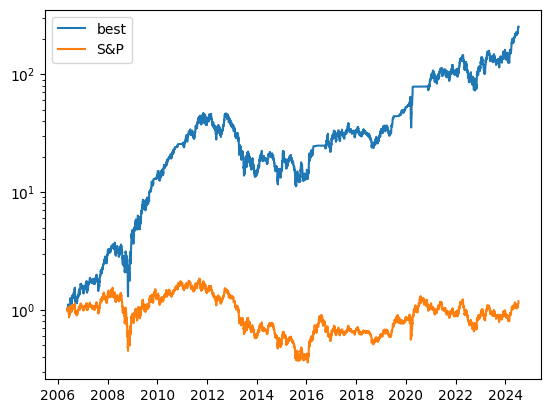

Round 2: 12.372445194163205
Round 3: 4.661425141060603
Round 4: nan
Round 5: 27.494096081896203
Round 6: nan
Round 7: 23.006766370766652
Round 8: 101.09951311241619
Round 9: 37.01736175011763
Round 10: 31.41464070443022
Round 11: 29.377157299182286
Round 12: 13.382290557756813
Round 13: 1.535225914544272
Round 14: nan
Round 15: nan
Round 16: nan
Round 17: 30.102235409779475
Round 18: nan
Round 19: 144.83450316984846
Round 20: 54.70163701445884
Round 21: 81.55730547819809
Round 22: nan
Round 23: 17.865003049126017
Round 24: nan
Round 25: 68.97846586456998
Round 26: 21.641243771605023
Round 27: nan
Round 28: 2.7926907286567504
Round 29: nan
Round 30: 1.5912160819949845
Round 31: 2.1370290444778903
Round 32: nan
Round 33: 2.9469565540445593
Round 34: nan
Round 35: nan
Round 36: 16.803674053254007
Round 37: 21.78454003322393
Round 38: 13.558572397538706
Round 39: 86.82192874958639
Round 40: 131.31516028092685
Round 41: 1.4476576789633808
Round 42: 20.607462051399782
Round 43: 2.60399066695

In [18]:
best_out, params_out = run_simulation(
    df.copy(), current_best=current_best, best_params=best_params)

Factor: 1.0625
Do nothing res: 1.1854939473204686
Round 1: 108.11153503143339
Round 2: 152.4560566274655
Round 3: 174.33686479824166
Round 4: 152.40094824154207
Round 5: 156.7973769075143
Round 6: 151.28374264839547
Round 7: 102.26014040587134
Round 8: 112.2753001587464
Round 9: 151.15577301976754
Round 10: 94.16527065375246
Round 11: 155.97552586970872
Round 12: 261.517623594088
New best: 261.517623594088
{'time_param': 165, 'method': 'ew', 't': 0.8486660323903517, 'k': 6.48729158936729, 'as_q': True, 'transform_f': 'bounded_sigmoid'}


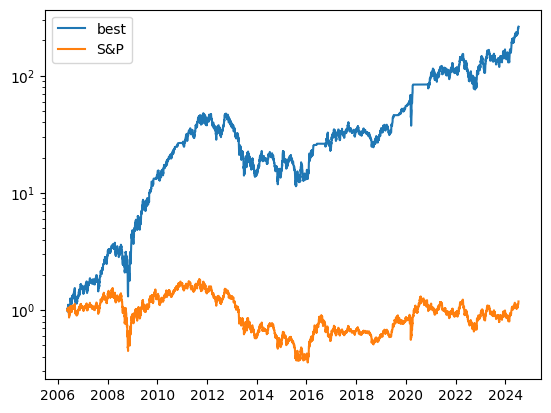

Round 13: 216.18922725974974
Round 14: 98.19852325995532
Round 15: 23.599652465300746
Round 16: 151.15188169694466
Round 17: 158.8613112282575
Round 18: 189.1512536400354
Round 19: 102.73051704105129
Round 20: 151.64846439620518
Round 21: 170.9499262684695
Round 22: 104.60495564943352
Round 23: 155.98590475875844
Round 24: 169.13251931391025
Round 25: 151.22408951191193

Factor: 1.03125
Do nothing res: 1.1854939473204686
Round 1: 61.31367578161422
Round 2: 8.996820350496385
Round 3: 229.54956729620218
Round 4: 51.01115546068574
Round 5: 109.7017555293931
Round 6: 182.81031446787375
Round 7: 99.60468414344156
Round 8: 152.44278397155483
Round 9: 183.94832463435228
Round 10: 263.1165571652096
New best: 263.1165571652096
{'time_param': 168, 'method': 'ew', 't': 0.8336041772403311, 'k': 6.391958421985668, 'as_q': True, 'transform_f': 'bounded_sigmoid'}


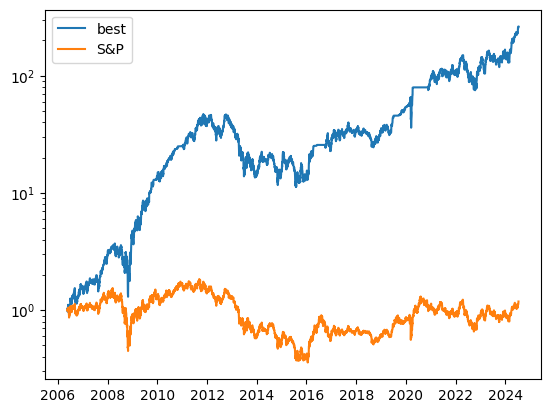

Round 11: 238.87529429999896
Round 12: 152.40717742016886
Round 13: 10.808985532756846
Round 14: 272.60037689622146
New best: 272.60037689622146
{'time_param': 171, 'method': 'ew', 't': 0.8754528824146759, 'k': 6.497596861673601, 'as_q': True, 'transform_f': 'bounded_sigmoid'}


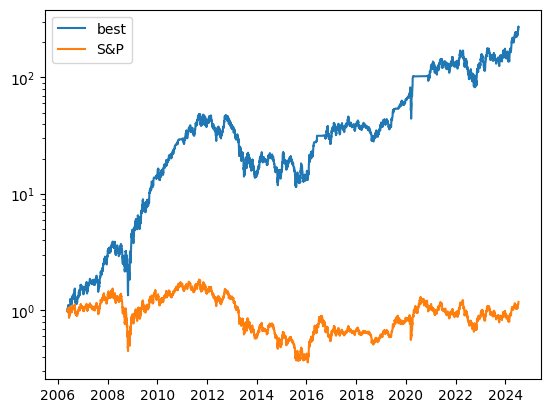

Round 15: 155.71921136025745
Round 16: 155.39271637909465
Round 17: 108.20228850786535
Round 18: 183.81738616220562
Round 19: 83.98303949649586
Round 20: 152.38424516686572
Round 21: 152.45197002786648
Round 22: 107.85232814362526
Round 23: 168.06699197910444
Round 24: 213.6254218590065
Round 25: 104.17267083869513

Factor: 1.015625
Do nothing res: 1.1854939473204686
Round 1: 40.256659311153584
Round 2: 258.8571460581541
Round 3: 54.5736294082255
Round 4: 174.01657621730183
Round 5: 104.44247568278574
Round 6: 155.7247385287767
Round 7: 111.25633176547288
Round 8: 155.97634947313531
Round 9: 265.27735435112817
Round 10: 5.570108159452434
Round 11: 155.71875917049212
Round 12: 269.03151997650616
Round 13: 155.72470460722113
Round 14: 102.31398461638868
Round 15: 155.71963005172478
Round 16: 155.964518669193
Round 17: 196.28010582384712
Round 18: 277.85500329006646
New best: 277.85500329006646
{'time_param': 170, 'method': 'ew', 't': 0.8641872004254593, 'k': 6.519863608506594, 'as_q': Tr

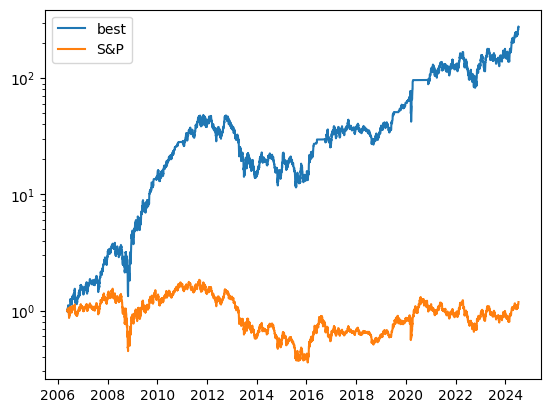

Round 19: 155.96184071595695
Round 20: 3.5638287283027332
Round 21: 93.14184375993513
Round 22: 155.98001660710872
Round 23: 111.38523165321418
Round 24: 266.62505663701893
Round 25: 163.14815756256212

Factor: 1.0078125
Do nothing res: 1.1854939473204686
Round 1: 107.92569569893631
Round 2: 207.8550582196893
Round 3: 63.2765128016422
Round 4: 155.97528589679783
Round 5: 155.3810421952256
Round 6: 155.38256979178158
Round 7: 166.72470964452245
Round 8: 107.47530292692863
Round 9: 54.30166318319325
Round 10: 254.94779680681518
Round 11: 108.46082038481896
Round 12: 40.404708410766986
Round 13: 167.77515246518675
Round 14: 62.76648593137687
Round 15: 155.38172263172908
Round 16: 108.62660864047639
Round 17: 189.98084516567653
Round 18: 155.38462339605803
Round 19: 195.47021799808303
Round 20: 105.43802641744078
Round 21: 155.97104144614264
Round 22: 155.38486677870338
Round 23: 172.48991036017034
Round 24: 124.97061052176552
Round 25: 155.96753943279396



In [19]:
# initially [1/4, 1/2, 1, 2]
for w in [16, 32, 64, 128]:  # bigger w -> smaller factor -> smaller changes
    factor = 1 + (1/w)
    print('Factor:', factor)
    best_out, params_out = run_simulation(
        df.copy(), 
        iters=25, 
        current_best=best_out, 
        best_params=params_out, 
        param_select='tweak',
        factor=factor,  # closer to 1: small changes; bigger: bigger
        numeric_only=True) 
    print()

In [20]:
# Force set:
#best_out = 8.746647001172413
#params_out = {'time_param': 39, 'method': 'ma', 't': 0.9119734669470952, 'k': 6.934678320149607, 'as_q': True, 'transform_f': 'bounded_curve'}

In [29]:
final_out = simulate(df, params_out)

In [30]:
amt_in = final_out['amt_in'][-1]
amt_in

0.01740000604139247

In [31]:
trend_fac = final_out['trend_factor'][-1]
trend_fac

0.9132530120481928

In [32]:
params_out

{'time_param': 170,
 'method': 'ew',
 't': 0.8641872004254593,
 'k': 6.519863608506594,
 'as_q': True,
 'transform_f': 'bounded_sigmoid'}

/Users/damiansp/Learning/marketModeling/notebooks/../utils/amt_inout.py:48: RuntimeWarning: divide by zero encountered in power
  y = 1 / (1 + (x**(np.log(2) / np.log(t)) - 1) ** k)


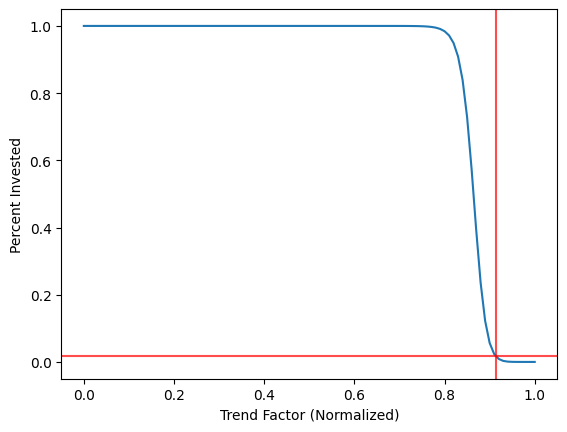

In [33]:
xs = np.linspace(0, 1, 101)
if params_out['transform_f'] == 'bounded_curve':
    ys = bounded_curve(xs, params_out['t'], params_out['k'], 'down')
else:
    ys = bounded_sigmoid(xs, params_out['t'], params_out['k'], 'down')
plt.xlabel('Trend Factor (Normalized)')
plt.ylabel('Percent Invested')
plt.plot(xs, ys)
plt.axhline(amt_in, color='r', alpha=0.7)
plt.axvline(trend_fac, color='r', alpha=0.7);

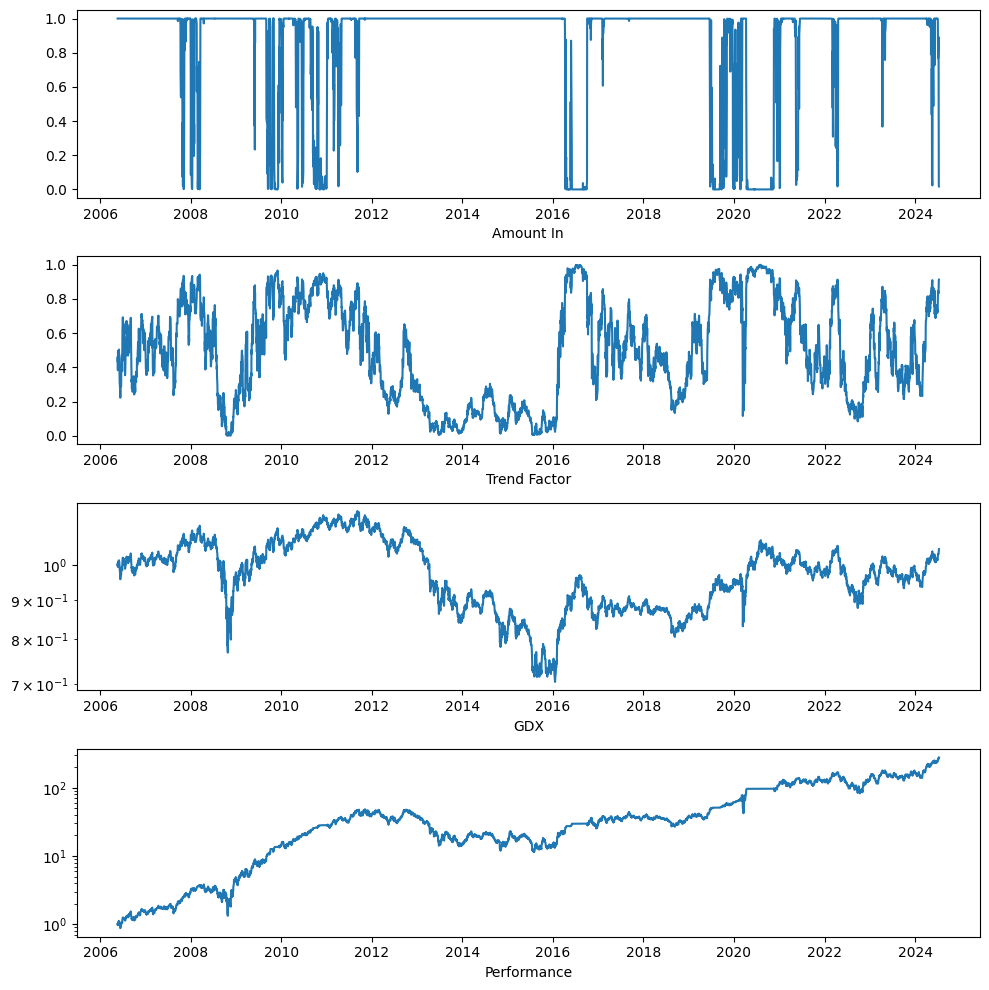

In [34]:
plt.figure(figsize=(10, 10))
plt.subplot(4, 1, 1)
plt.plot(final_out.amt_in)
plt.xlabel('Amount In')

plt.subplot(4, 1, 2)
plt.plot(final_out.trend_factor)
plt.xlabel('Trend Factor')

plt.subplot(4, 1, 3)
plt.plot(final_out.logval / final_out.logval[0])
plt.xlabel('GDX')
plt.yscale('log')

plt.subplot(4, 1, 4)
plt.plot(final_out.total)
plt.xlabel('Performance')
plt.yscale('log')
plt.tight_layout();

In [35]:
N = 500
#plt.figure(figsize=(10, 10))
#plt.subplot(4, 1, 1)
#plt.plot(final_out.amt_in[:N])
#plt.xlabel('Amount In')

#plt.subplot(4, 1, 2)
#plt.plot(final_out.trend_factor[:N])
#plt.xlabel('Trend Factor')

#plt.subplot(4, 1, 3)
#plt.plot((final_out.logval / final_out.logval[0])[:N])
#plt.xlabel('Wilshire')
#plt.yscale('log')

#plt.subplot(4, 1, 4)
#plt.plot(final_out.total[:N])
#plt.xlabel('Performance')
#plt.yscale('log')
#plt.tight_layout();

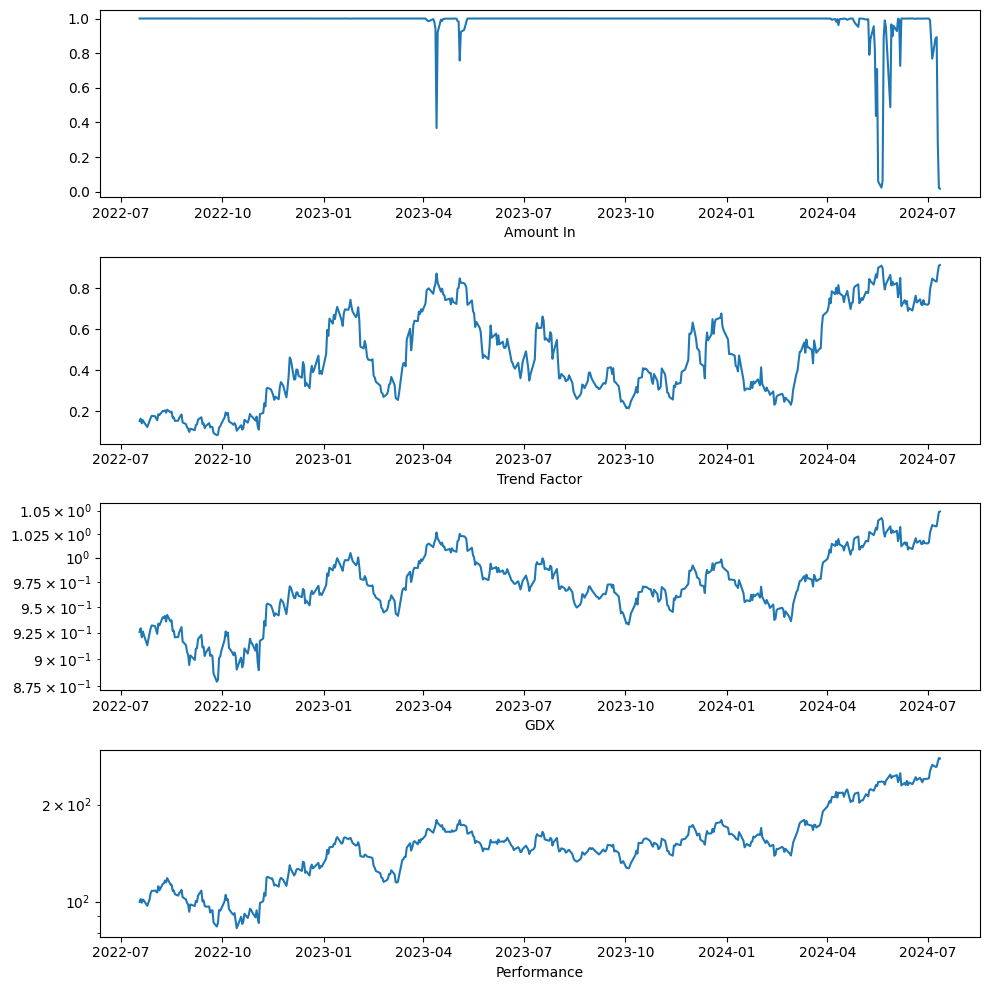

In [36]:
plt.figure(figsize=(10, 10))
plt.subplot(4, 1, 1)
plt.plot(final_out.amt_in[-N:])
plt.xlabel('Amount In')

plt.subplot(4, 1, 2)
plt.plot(final_out.trend_factor[-N:])
plt.xlabel('Trend Factor')

plt.subplot(4, 1, 3)
plt.plot((final_out.logval / final_out.logval[0])[-N:])
plt.xlabel('GDX')
plt.yscale('log')

plt.subplot(4, 1, 4)
plt.plot(final_out.total[-N:])
plt.xlabel('Performance')
plt.yscale('log')
plt.tight_layout();

In [67]:
with open(PARAM_PATH, 'wb') as f:
    pickle.dump([best_out, params_out], f)
    
best_out, params_out

(277.85500329006646,
 {'time_param': 170,
  'method': 'ew',
  't': 0.8641872004254593,
  'k': 6.519863608506594,
  'as_q': True,
  'transform_f': 'bounded_sigmoid'})

In [68]:
frac_in = round(final_out['amt_in'][-1], 4)
frac_in

0.0174

In [69]:
# n days
n = (df.index >= SIM_START).sum()
# n years
t = n / 250
# amt at start
p = df.loc[SIM_START, 'value']
amt = df.iloc[-1].value
p, t, amt

(32.197547912597656, 18.264, 38.16999816894531)

In [70]:
# annualized rate of return
r = best_out**(1/t) 
r - 1

0.3608341604830252

In [71]:
with open('daily_params.json', 'r') as f_in:
    j = json.load(f_in)
    with open('daily_params.json', 'w') as f_out:
        j['gdx'] = [r, frac_in]
        print(j)
        json.dump(j, f_out)

{'sp': [1.117876849072677, 0.9707], 'nas': [1.221824877675853, 0.9613], 'rus': [1.1796414650730493, 0.6677], 'jpxn': [1.0475688418507474, 0.2309], 'ktec': [1.6341333973019867, 0.0], 'emb': [1.0930267520260304, 0.9993], 'gdx': [1.3608341604830252, 0.0174], 'dia': [1.1408986698562857, 1.0]}


In [72]:
keys = ['sp', 'nas', 'dia', 'rus', 'jpxn', 'ktec', 'emb', 'gdx']
rs = np.array([j[k][0] - 1 for k in keys])

# Manually reduce KTEC & GDX
idx_ktec = keys.index('ktec')
rs[idx_ktec] /= 10
idx_gdx = keys.index('gdx')
rs[idx_gdx] /= 5
#

rs = rs / rs.sum()
for k, r in zip(keys, rs):
    print(f'{k:4s}: {r:.4f}')

sp  : 0.1259
nas : 0.2369
dia : 0.1505
rus : 0.1918
jpxn: 0.0508
ktec: 0.0677
emb : 0.0993
gdx : 0.0771


In [73]:
fracs_in = np.array([j[k][1]  for k in keys])
for k, f in zip(keys, fracs_in):
    print(f'{k:4s}: {f:.4f}')

sp  : 0.9707
nas : 0.9613
dia : 1.0000
rus : 0.6677
jpxn: 0.2309
ktec: 0.0000
emb : 0.9993
gdx : 0.0174


In [74]:
#                   SPY,   FNCMX,  DIA, IWF, JPXN, KTEC, EMB, GDX
current = np.array([17917, 139638, 0,   0,   0,    0,    0,   0])
cash = 30764
val = current.sum() + cash
target = (val * rs * fracs_in).round()
for k, t in zip(keys, target):
    print(f'{k:4s}: {t:7.0f}')

sp  :   23011
nas :   42884
dia :   28336
rus :   24122
jpxn:    2209
ktec:       0
emb :   18695
gdx :     253


In [75]:
for k, diff in zip(keys, target - current):
    print(f'{k:4s}: {diff:7.0f}')

sp  :    5094
nas :  -96754
dia :   28336
rus :   24122
jpxn:    2209
ktec:       0
emb :   18695
gdx :     253
